# Imports

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from outliertree import OutlierTree
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, fbeta_score, recall_score, make_scorer, precision_recall_curve, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

import skfuzzy as fuzz
from skfuzzy import control as ctrl


# Load the data

In [2]:
data = pd.read_csv('./data/alzheimers_disease_data.csv')
data.columns = [col.lower() for col in data.columns]


pd.set_option('display.max_columns', None)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2149 entries, 0 to 2148
Data columns (total 34 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   patientid                  2149 non-null   int64  
 1   age                        2149 non-null   int64  
 2   gender                     2149 non-null   int64  
 3   ethnicity                  2149 non-null   int64  
 4   educationlevel             2149 non-null   int64  
 5   bmi                        2149 non-null   float64
 6   smoking                    2149 non-null   int64  
 7   alcoholconsumption         2149 non-null   float64
 8   physicalactivity           2149 non-null   float64
 9   dietquality                2149 non-null   float64
 10  sleepquality               2149 non-null   float64
 11  familyhistoryalzheimers    2149 non-null   int64  
 12  cardiovasculardisease      2149 non-null   int64  
 13  diabetes                   2149 non-null   int64

In [3]:
data.head()

,patientid,age,gender,ethnicity,educationlevel,bmi,smoking,alcoholconsumption,physicalactivity,dietquality,sleepquality,familyhistoryalzheimers,cardiovasculardisease,diabetes,depression,headinjury,hypertension,systolicbp,diastolicbp,cholesteroltotal,cholesterolldl,cholesterolhdl,cholesteroltriglycerides,mmse,functionalassessment,memorycomplaints,behavioralproblems,adl,confusion,disorientation,personalitychanges,difficultycompletingtasks,forgetfulness,diagnosis
0,4751,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,9.025679,0,0,1,1,0,0,142,72,242.366840,56.150897,33.682564,162.189143,21.463532,6.518877,0,0,1.725883,0,0,0,1,0,0
1,4752,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,7.151293,0,0,0,0,0,0,115,64,231.162595,193.407995,79.028477,294.630909,20.613267,7.118696,0,0,2.592424,0,0,0,0,1,0
2,4753,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,9.673574,1,0,0,0,0,0,99,116,284.181858,153.322762,69.772292,83.638324,7.356249,5.895077,0,0,7.119548,0,1,0,1,0,0
3,4754,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,8.392554,0,0,0,0,0,0,118,115,159.582240,65.366637,68.457491,277.577358,13.991127,8.965106,0,1,6.481226,0,0,0,0,0,0
4,4755,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,5.597238,0,0,0,0,0,0,94,117,237.602184,92.869700,56.874305,291.198780,13.517609,6.045039,0,0,0.014691,0,0,1,1,0,0


# ------------
# Prediction target
## Prediction target = 'Diagnosis'
### 1 = AD, 0 = No AD 
### The model's purpose is for screening or triage. This isn't a final diagnosis; it's a tool to help doctors decide who needs more expensive, invasive, or specialized follow-up testing.
### A False Negative (FN) is the worst-case scenario: The model says a patient is 'Non-AD', but they actually have AD. This person is sent home without further assessment, allowing the disease to progress untreated. A False Positive (FP) is also undesirable but less costly: The model says a patient is 'AD', but they are 'Non-AD'. This patient is sent for unnecessary (and likely expensive) follow-up tests, but they are ultimately found to be healthy.

### But, as it concerns human lives, the focus will be to identify as much as true positives as possible. 


## Metrics

### Primary Metric: Recall (Sensitivity)
### Balancing Metric: Specificity
### Combined Metric: F2-Score
### Overall Model Metric: AUC-ROC





# -----------------

# Data preperation 
## Fix categorical values

In [4]:
bool_cols = ['gender', 'ethnicity', 'educationlevel', 'smoking', 'familyhistoryalzheimers', 'cardiovasculardisease', 'diabetes', 'depression', 'headinjury', 'hypertension', 'memorycomplaints', 'behavioralproblems', 'confusion', 'disorientation', 'personalitychanges', 'difficultycompletingtasks', 'forgetfulness', 'diagnosis']
for col in bool_cols:
    data[col] = data[col].astype('category')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2149 entries, 0 to 2148
Data columns (total 34 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   patientid                  2149 non-null   int64   
 1   age                        2149 non-null   int64   
 2   gender                     2149 non-null   category
 3   ethnicity                  2149 non-null   category
 4   educationlevel             2149 non-null   category
 5   bmi                        2149 non-null   float64 
 6   smoking                    2149 non-null   category
 7   alcoholconsumption         2149 non-null   float64 
 8   physicalactivity           2149 non-null   float64 
 9   dietquality                2149 non-null   float64 
 10  sleepquality               2149 non-null   float64 
 11  familyhistoryalzheimers    2149 non-null   category
 12  cardiovasculardisease      2149 non-null   category
 13  diabetes                   2149 n

## Check Balance

In [5]:
def check_balance(target):
    print("\n--- Target Variable Class Balance ---")
    print(data[target].value_counts(normalize=True))

check_balance('diagnosis')


--- Target Variable Class Balance ---
diagnosis
0    0.646347
1    0.353653
Name: proportion, dtype: float64


## Check missing values

In [6]:
missing_values = data.isnull().sum()

if missing_values.any() > 0:
    print(missing_values)
else:
    print('No missing values!')

No missing values!


## Check outliers

In [7]:
ot = OutlierTree()
out_train = ot.fit(data.select_dtypes(include=[np.number]))
print(out_train)

No outliers found in input data.

OutlierTree model
	Numeric variables: 16

Consists of 16 clusters, spread across 16 tree branches



### Splitting features

In [8]:
continuous_features = data.select_dtypes(include=['int64', 'float64']).columns.drop('patientid')
categorical_features = data.select_dtypes(include=['object', 'category']).columns


print(f'Continuous variables: {continuous_features}')
print(f'Categorical variables: {categorical_features}')


Continuous variables: Index(['age', 'bmi', 'alcoholconsumption', 'physicalactivity', 'dietquality',
       'sleepquality', 'systolicbp', 'diastolicbp', 'cholesteroltotal',
       'cholesterolldl', 'cholesterolhdl', 'cholesteroltriglycerides', 'mmse',
       'functionalassessment', 'adl'],
      dtype='object')
Categorical variables: Index(['gender', 'ethnicity', 'educationlevel', 'smoking',
       'familyhistoryalzheimers', 'cardiovasculardisease', 'diabetes',
       'depression', 'headinjury', 'hypertension', 'memorycomplaints',
       'behavioralproblems', 'confusion', 'disorientation',
       'personalitychanges', 'difficultycompletingtasks', 'forgetfulness',
       'diagnosis'],
      dtype='object')


### Continuous plots

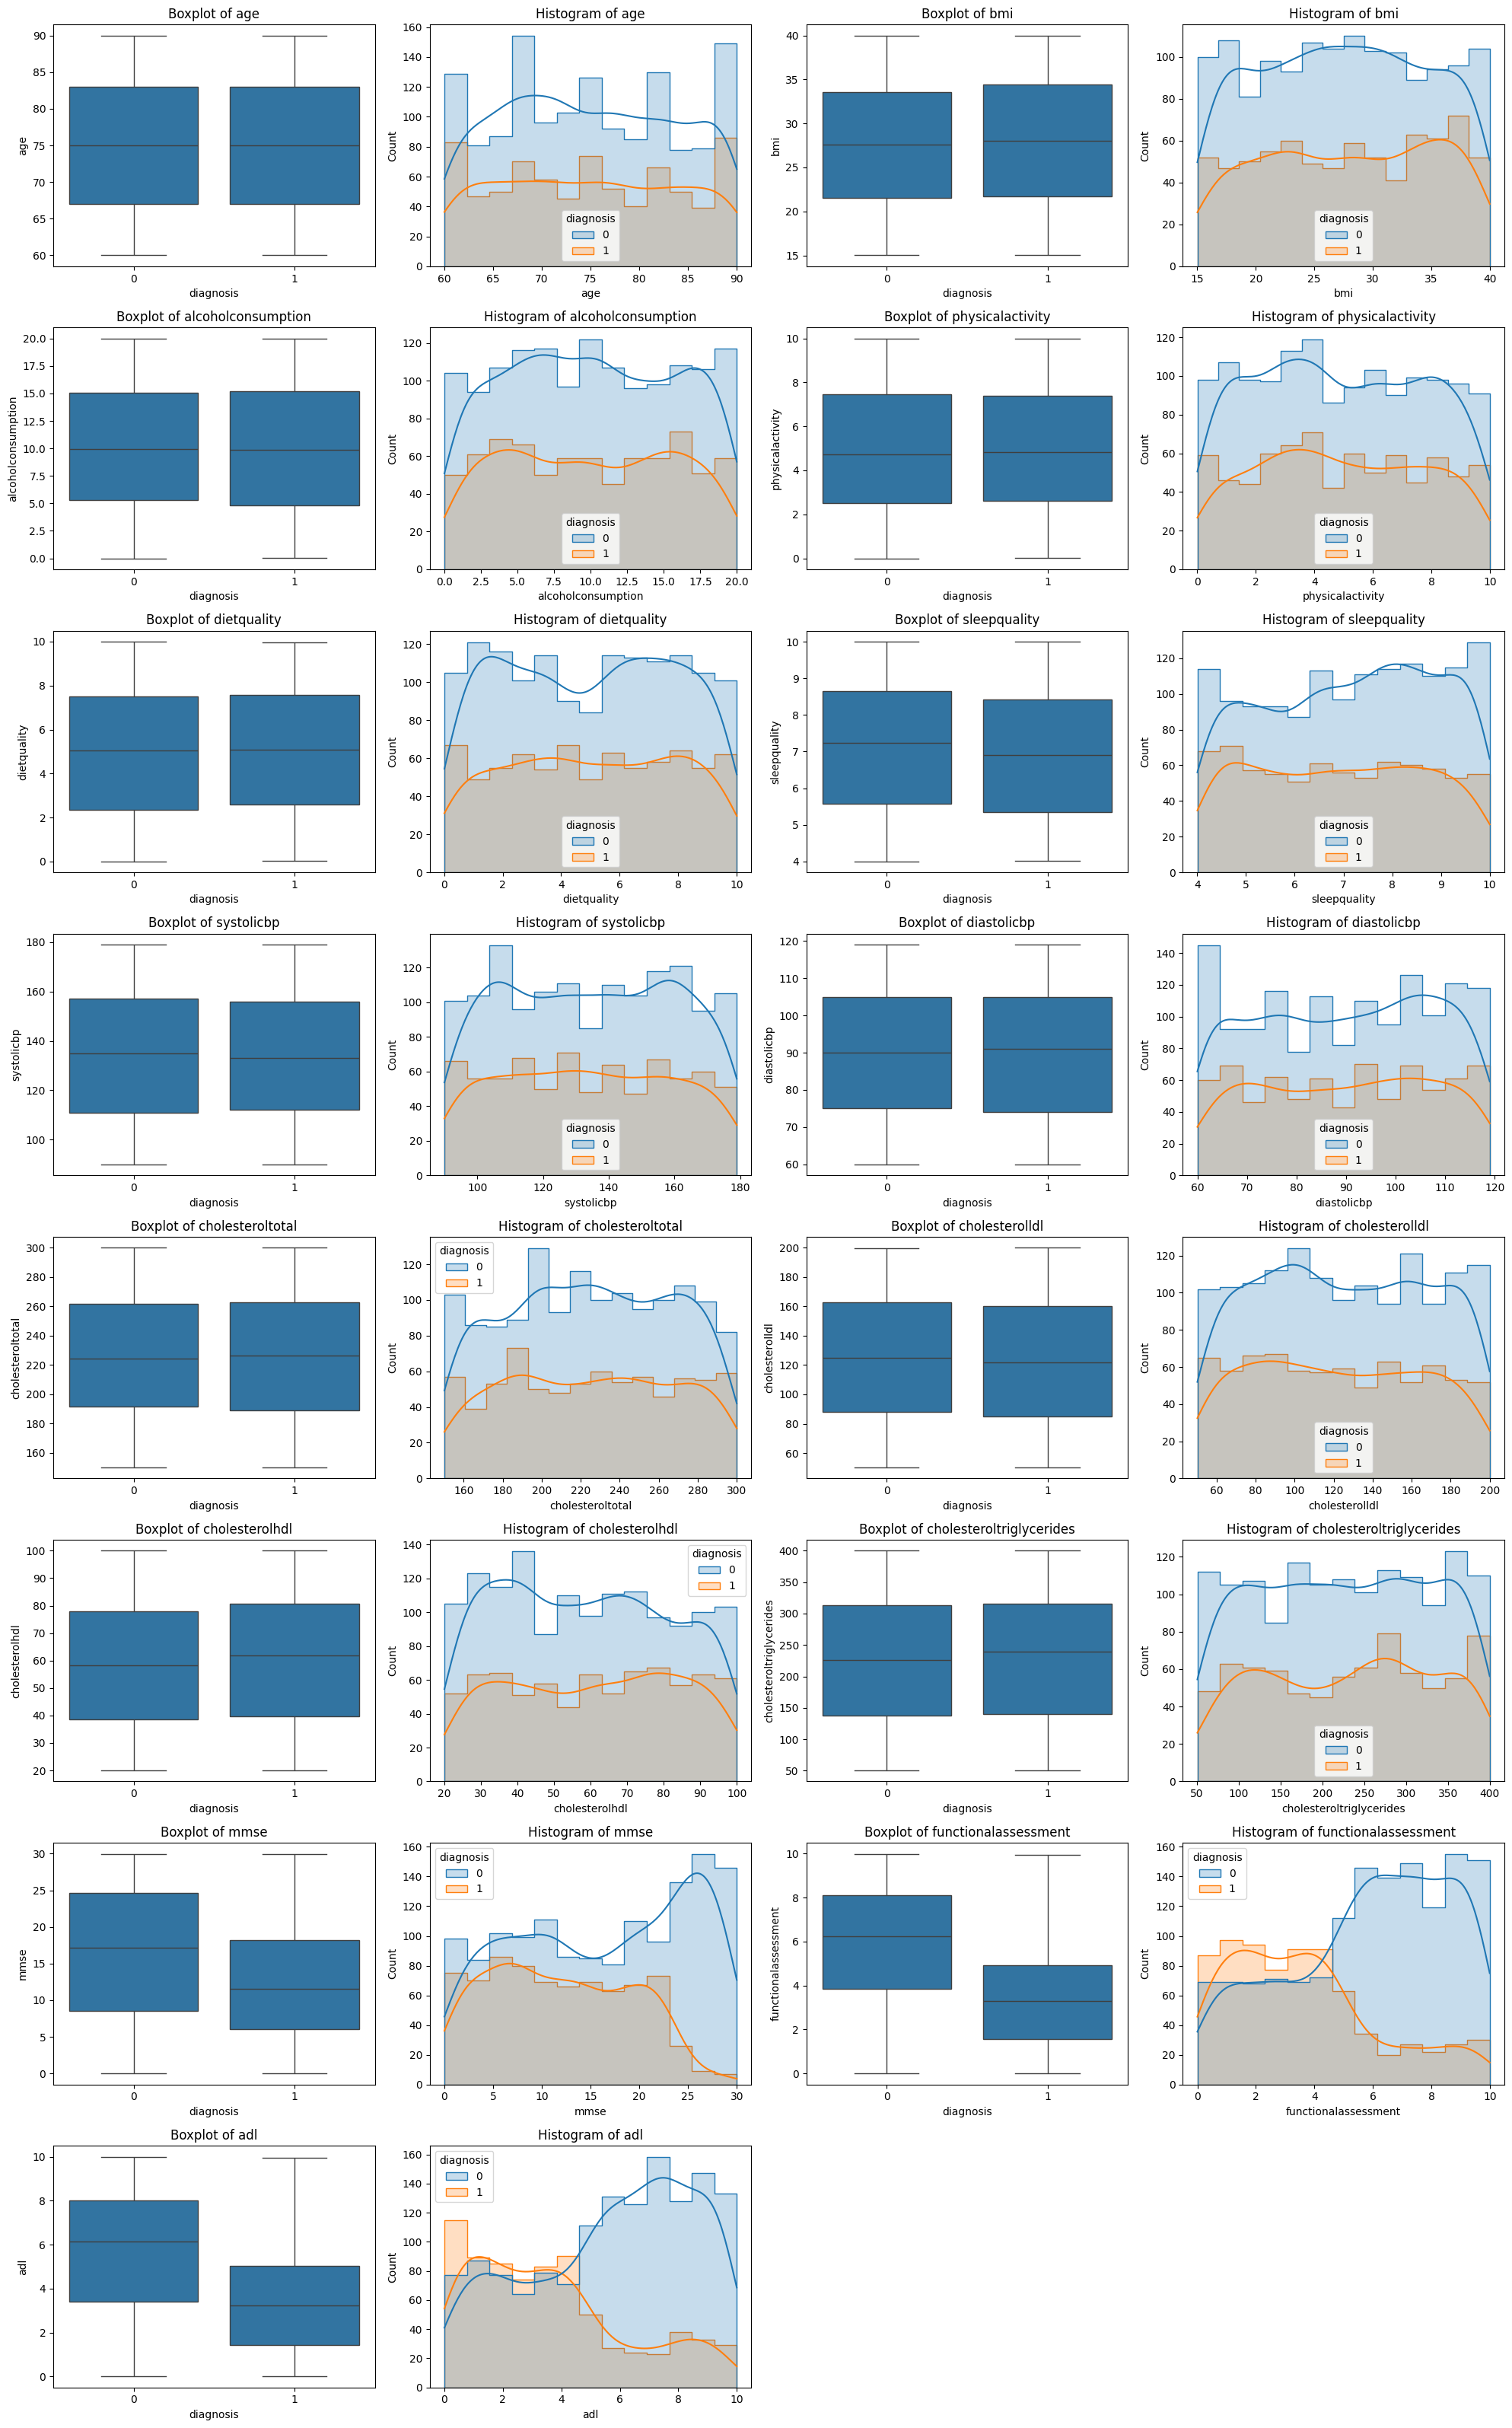

In [9]:
n_cols = 4
n_features = len(continuous_features)
n_plots_per_feature = 2 
n_total_plots = n_features * n_plots_per_feature
n_rows = (n_total_plots + n_cols - 1) // n_cols
    
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten()

for idx, col in enumerate(continuous_features):
    plot_base_index = idx * n_plots_per_feature 

    ax_box = axes[plot_base_index]
    ax_hist = axes[plot_base_index + 1]
    
    # Boxplot
    sns.boxplot(x='diagnosis', y=col, data=data, ax=ax_box)
    ax_box.set_title(f'Boxplot of {col}')

    # Histogram/KDE
    sns.histplot(data=data, x=col, hue='diagnosis', kde=True, element="step", ax=ax_hist)
    ax_hist.set_title(f'Histogram of {col}')

for i in range(n_total_plots, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.savefig(f'plots/EDA_contxdiag.png')
plt.show()

### Categorical plots

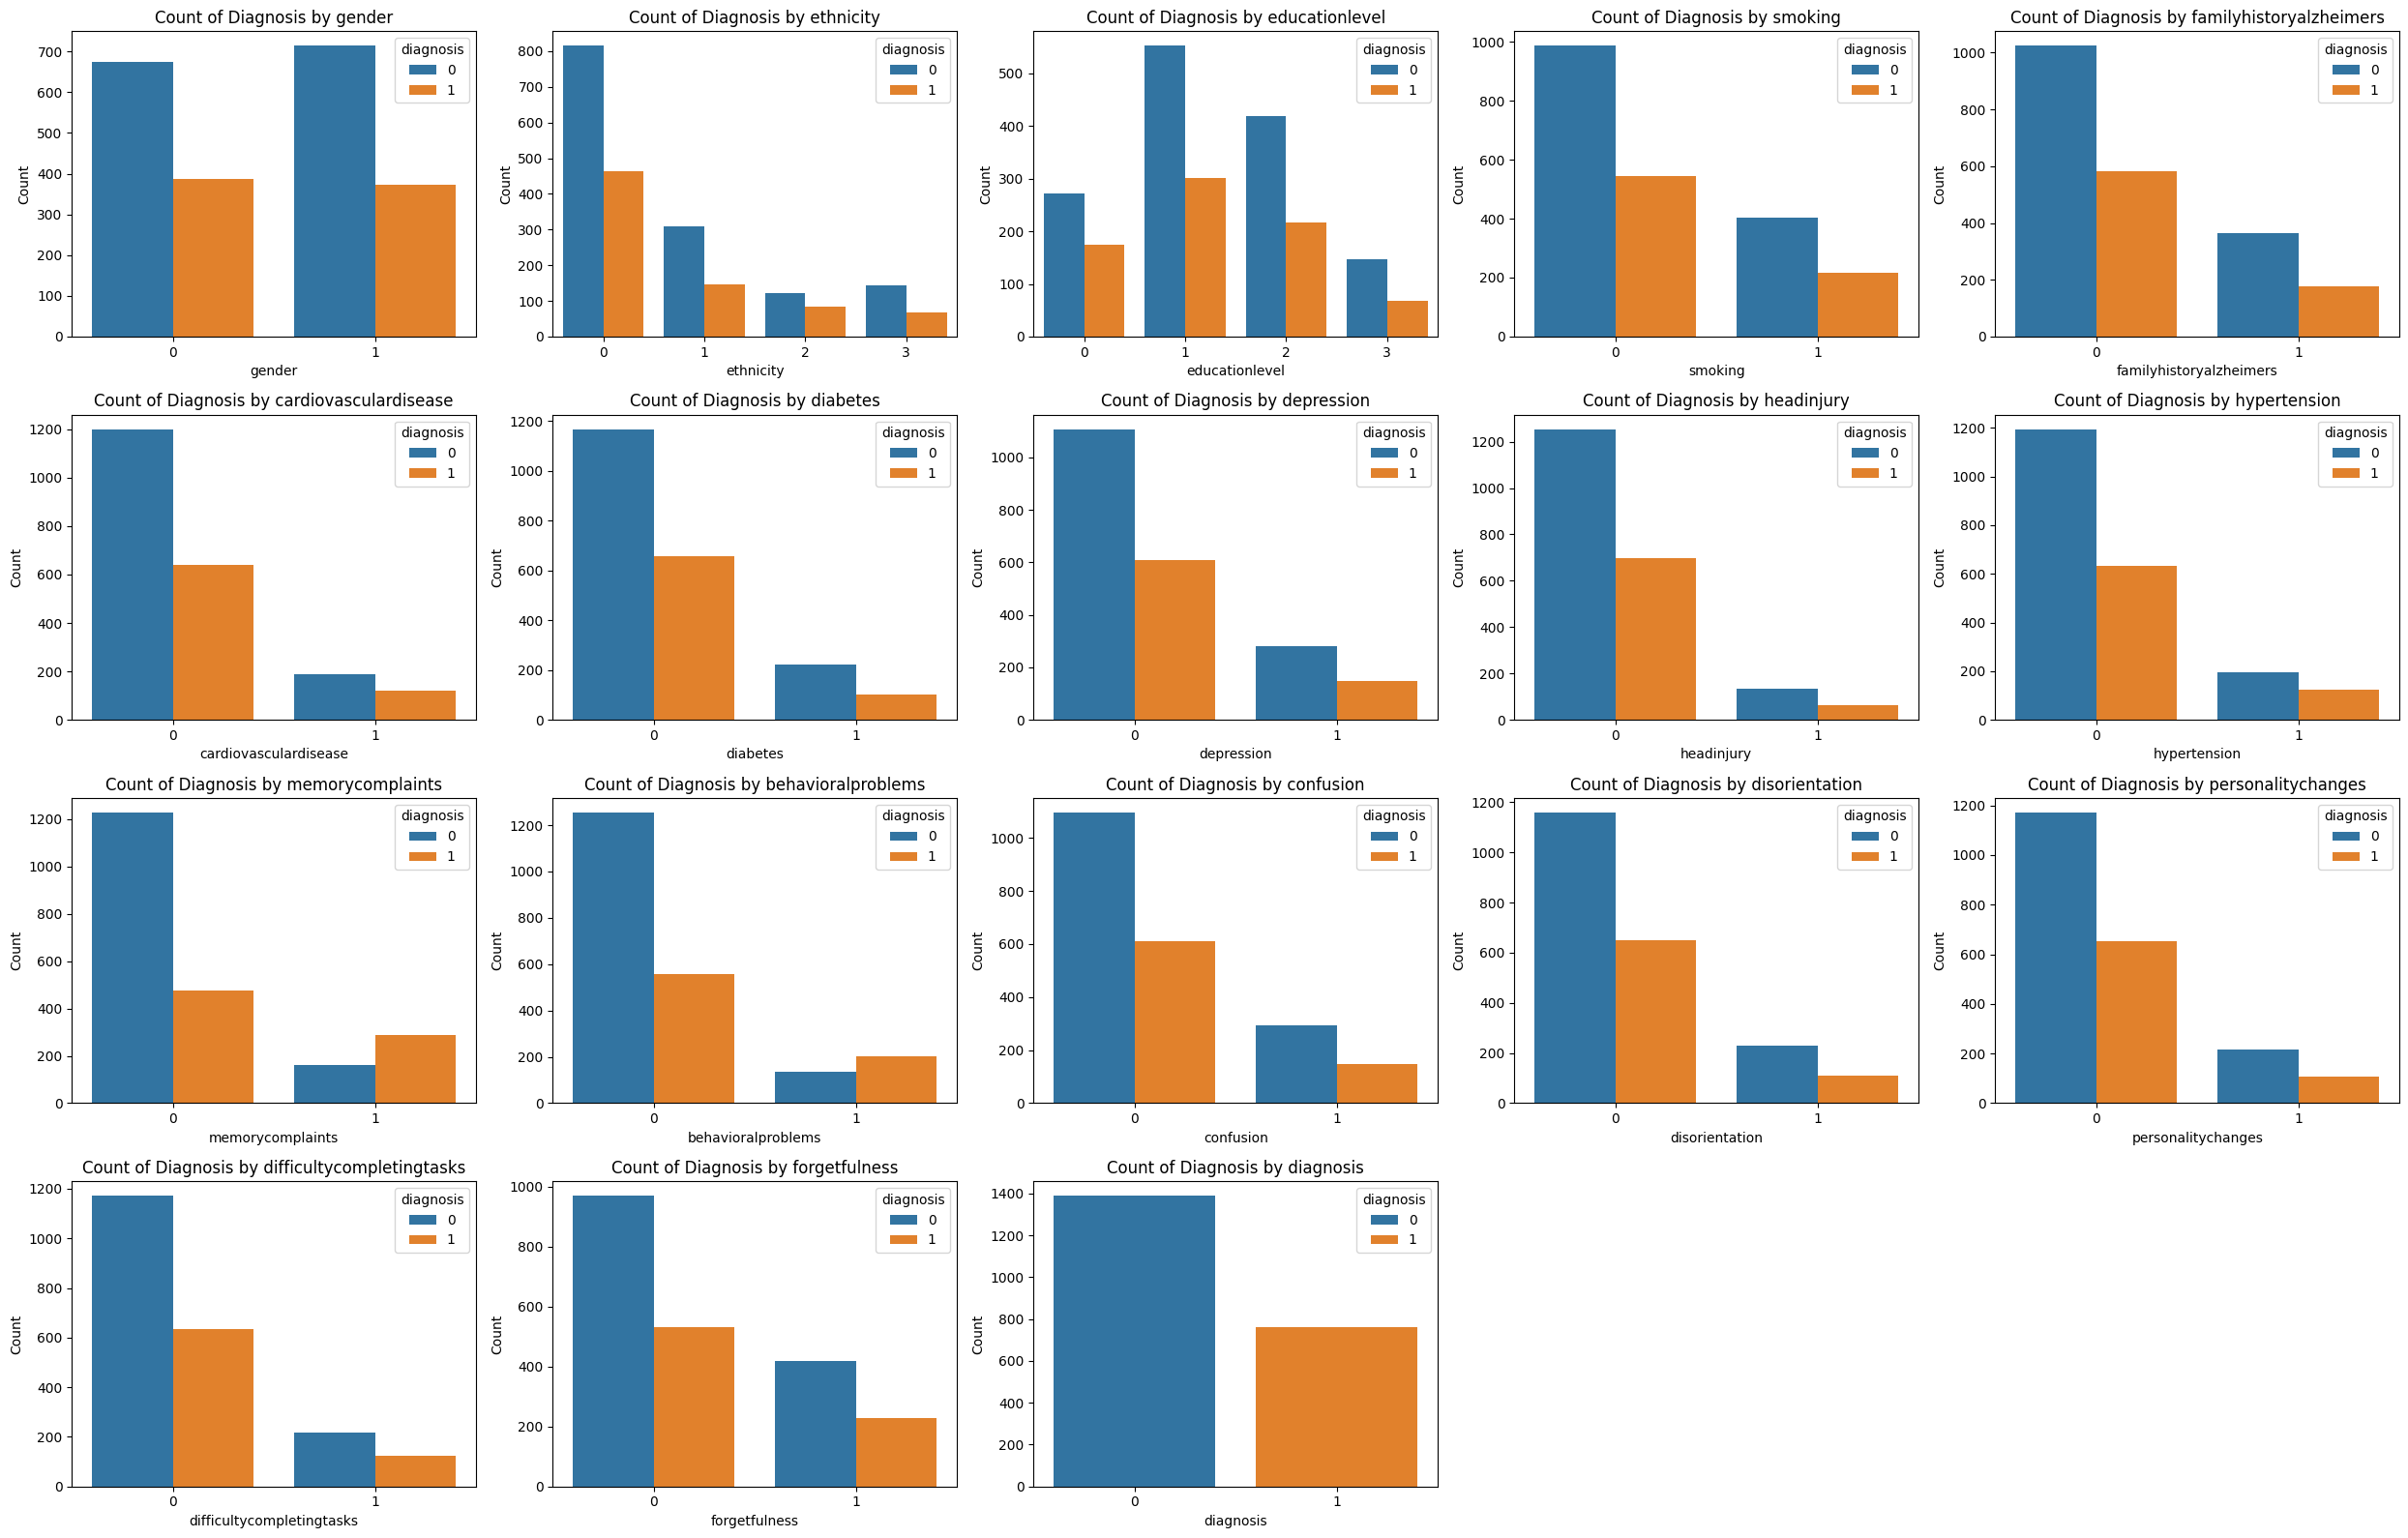

In [10]:
n_cols = 5  
n_features = len(categorical_features)
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten()

for idx, col in enumerate(categorical_features):
    ax = axes[idx] 
    sns.countplot(x=col, hue='diagnosis', data=data, ax=ax)

    ax.set_title(f'Count of Diagnosis by {col}')
    ax.set_ylabel('Count')

for idx in range(n_features, len(axes)):
    axes[idx].axis('off')

plt.tight_layout() 
plt.savefig(f'plots/EDA_catxdiag.png') 
plt.show()

### Individual plotting (optional)

In [11]:
def individual_catxdiag_plots():
    for i, col in enumerate(categorical_features):
        plt.figure(figsize=(8, 6))

        sns.countplot(x=col, hue='diagnosis', data=data)
        plt.title(f'Count of Diagnosis by {col}')
        plt.ylabel('Count')
    
        plt.tight_layout()
        plt.savefig(f'plots\EDA_plot_cat_{i}_{col}.png')
        plt.show()

def individual_contxdiag_plots():
    for i, col in enumerate(continuous_features):
        plt.figure(figsize=(12, 5))

        # Boxplot
        plt.subplot(1, 2, 1)
        sns.boxplot(x='diagnosis', y=col, data=data)
        plt.title(f'Boxplot of {col} by Diagnosis')

        # Histogram/KDE
        plt.subplot(1, 2, 2)
        sns.histplot(data=data, x=col, hue='diagnosis', kde=True, element="step")
        plt.title(f'Histogram of {col} by Diagnosis')

        plt.tight_layout()
        plt.savefig(f'plots\EDA_plot_cont_{i}_{col}.png')
        plt.show()

#individual_catxdiag_plots()
#individual_contxdiag_plots()


<>:10: SyntaxWarning: "\E" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\E"? A raw string is also an option.
<>:28: SyntaxWarning: "\E" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\E"? A raw string is also an option.
<>:10: SyntaxWarning: "\E" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\E"? A raw string is also an option.
<>:28: SyntaxWarning: "\E" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\E"? A raw string is also an option.
C:\Users\20193583\AppData\Local\Temp\ipykernel_19420\3704996884.py:10: SyntaxWarning: "\E" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\E"? A raw string is also an option.
  plt.savefig(f'plots\EDA_plot_cat_{i}_{col}.png')
C:\Users\20193583\AppData\Local\Temp\ipykernel_19420\3704996884.py:28: SyntaxWarning: "\E" is an invalid escape seq

## Distributions
### Categorical distributions

<>:16: SyntaxWarning: "\d" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\d"? A raw string is also an option.
<>:16: SyntaxWarning: "\d" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\d"? A raw string is also an option.
C:\Users\20193583\AppData\Local\Temp\ipykernel_19420\1805698616.py:16: SyntaxWarning: "\d" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\d"? A raw string is also an option.
  plt.savefig(f'plots\distribution_cat.png')


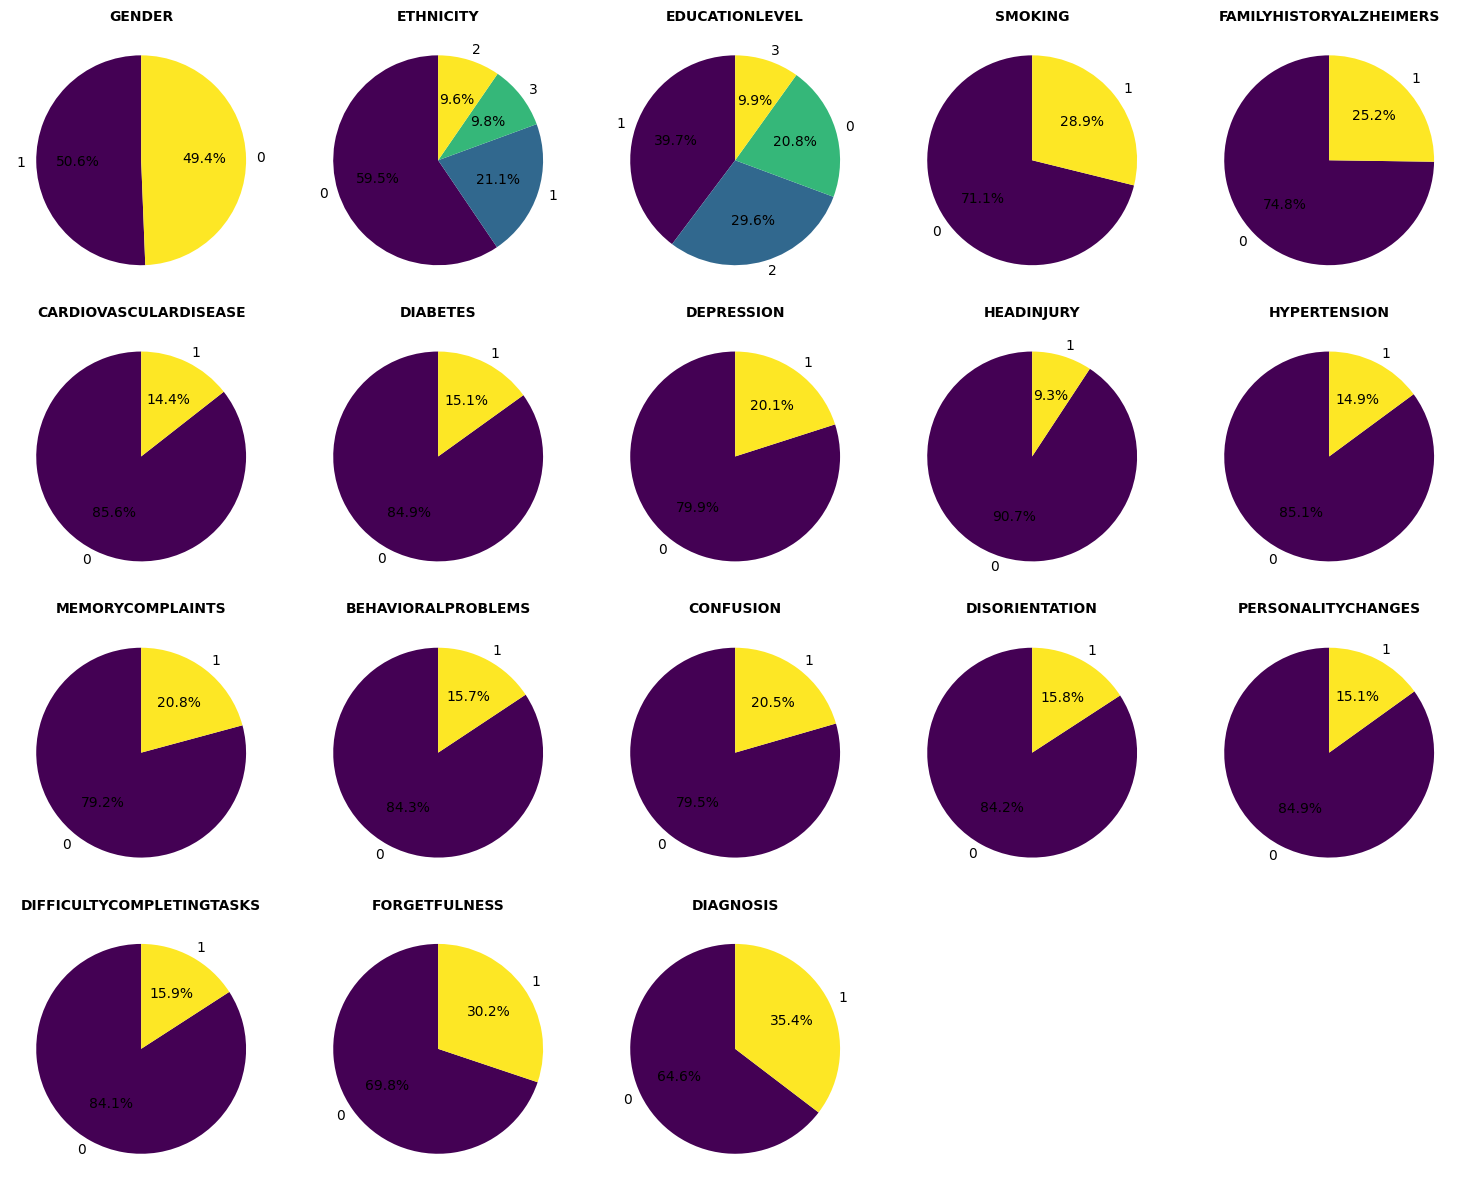

In [12]:
n_cols = 5
n_rows = (len(categorical_features) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 3))
axes = axes.flatten()

for idx, col in enumerate(categorical_features):
    data[col].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, cmap='viridis', ax=axes[idx])
    axes[idx].set_title(f'{col.upper()}', fontsize=10, fontweight='bold')
    axes[idx].set_ylabel('')

for idx in range(len(categorical_features), len(axes)):
    axes[idx].axis('off')
    
plt.tight_layout()
plt.savefig(f'plots\distribution_cat.png')
plt.show()

### Numerical distributions

<>:18: SyntaxWarning: "\d" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\d"? A raw string is also an option.
<>:18: SyntaxWarning: "\d" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\d"? A raw string is also an option.
C:\Users\20193583\AppData\Local\Temp\ipykernel_19420\3693448599.py:18: SyntaxWarning: "\d" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\d"? A raw string is also an option.
  plt.savefig(f'plots\distribution_cont.png')


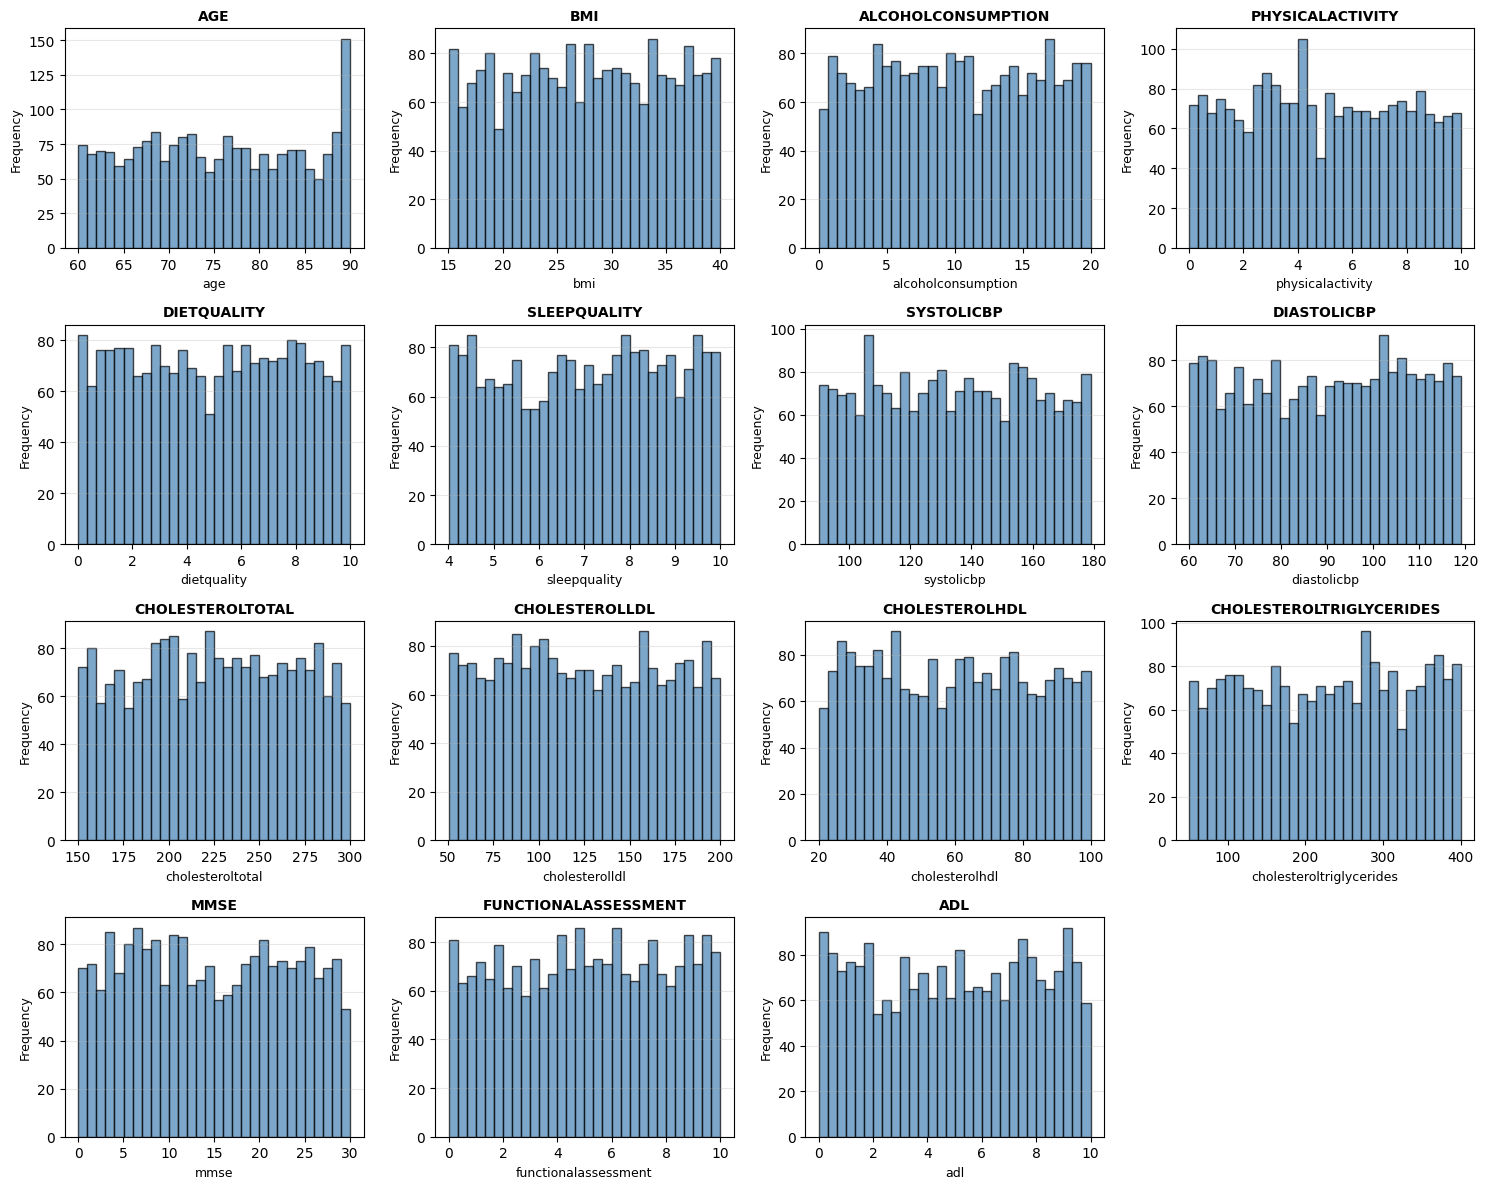

In [13]:
n_cols = 4
n_rows = (len(continuous_features) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 3))
axes = axes.flatten()

for idx, col in enumerate(continuous_features):
    axes[idx].hist(data[col].dropna(), bins=30, color='steelblue', alpha=0.7, edgecolor='black')
    axes[idx].set_title(f'{col.upper()}', fontsize=10, fontweight='bold')
    axes[idx].set_xlabel(col, fontsize=9)
    axes[idx].set_ylabel('Frequency', fontsize=9)
    axes[idx].grid(axis='y', alpha=0.3)

for idx in range(len(continuous_features), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig(f'plots\distribution_cont.png')
plt.show()

### Correlation Heatmap

<>:9: SyntaxWarning: "\E" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\E"? A raw string is also an option.
<>:9: SyntaxWarning: "\E" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\E"? A raw string is also an option.
C:\Users\20193583\AppData\Local\Temp\ipykernel_19420\362967799.py:9: SyntaxWarning: "\E" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\E"? A raw string is also an option.
  plt.savefig('plots\EDA_correlation_heatmap.png')


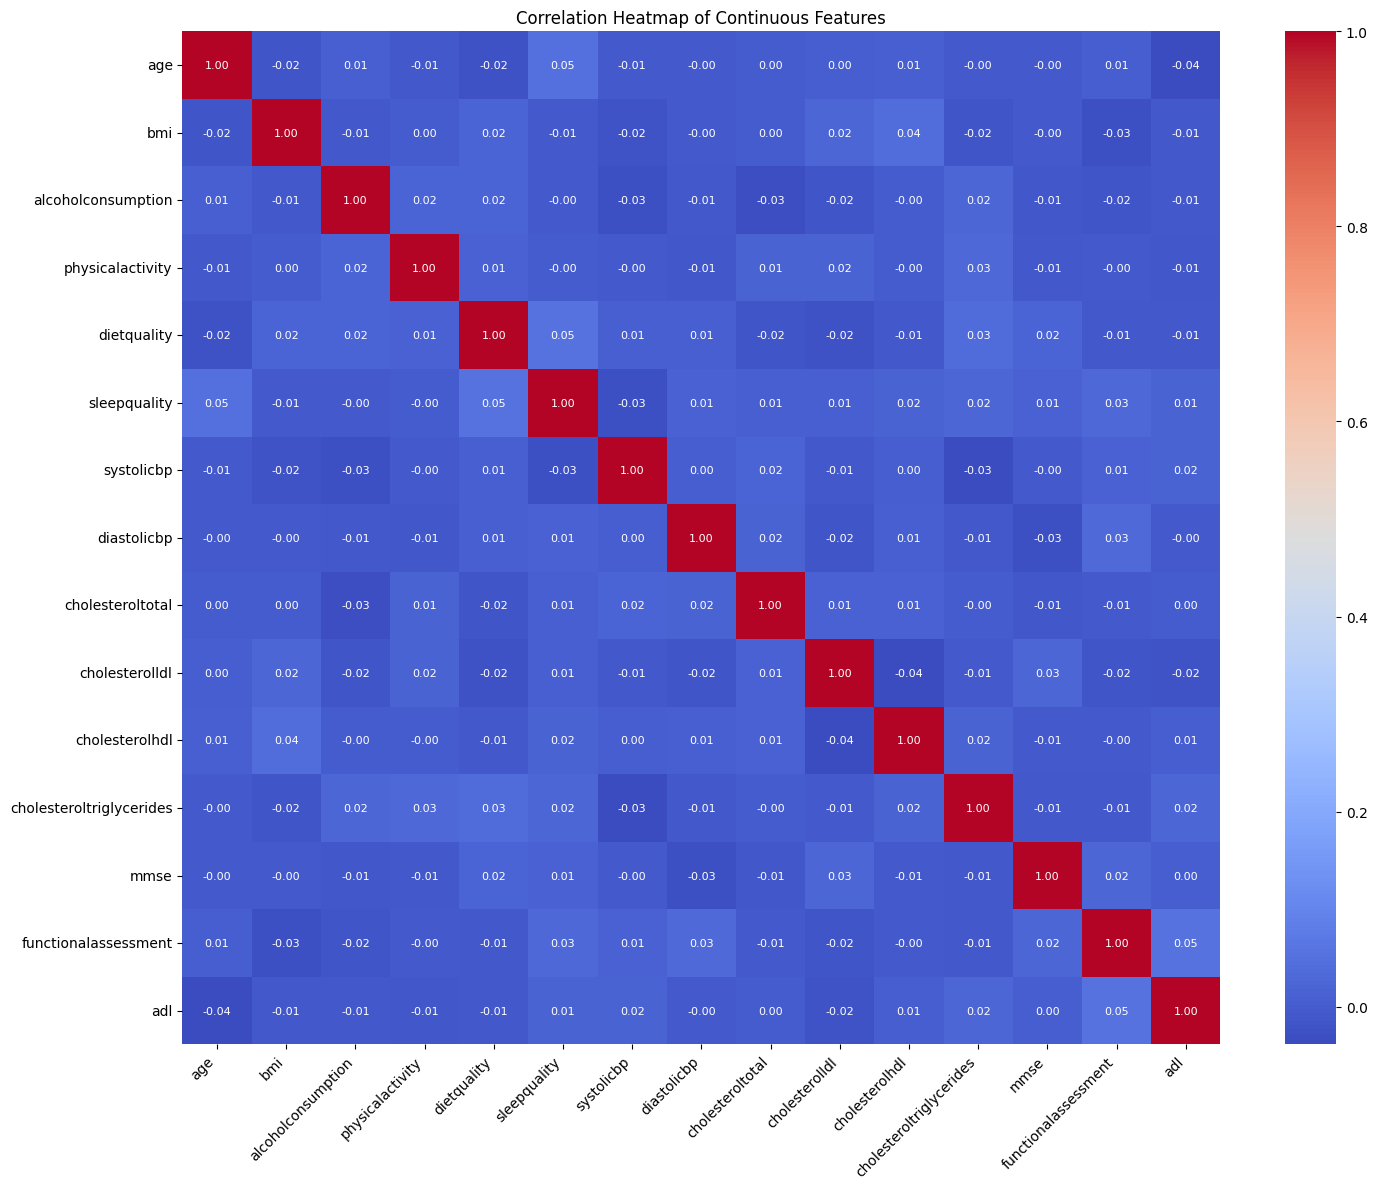

In [14]:
plt.figure(figsize=(15, 12))
corr_matrix = data[continuous_features].corr() 
    
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', annot_kws={"size": 8})
plt.title('Correlation Heatmap of Continuous Features')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('plots\EDA_correlation_heatmap.png')
plt.show()

# Preprocessing
#### Defining X and Y

In [15]:
y = data['diagnosis']
X = data.drop(['diagnosis', 'patientid'], axis=1)

continuous_features_list = continuous_features.tolist()
categorical_features_list = categorical_features.drop('diagnosis').tolist()

print(f"Continuous features for pipeline: {len(continuous_features_list)}")
print(f"Categorical features for pipeline: {len(categorical_features_list)}")

Continuous features for pipeline: 15
Categorical features for pipeline: 17


#### Defining preprocessor

In [16]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first')) # drop='first' om multicollineariteit te voorkomen
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, continuous_features_list),
        ('cat', categorical_transformer, categorical_features_list)
    ],
    remainder='passthrough')

#### Train test split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train balans:\n{y_train.value_counts(normalize=True)}")
print(f"y_test balans:\n{y_test.value_counts(normalize=True)}")

X_train shape: (1719, 32)
X_test shape: (430, 32)
y_train balans:
diagnosis
0    0.646306
1    0.353694
Name: proportion, dtype: float64
y_test balans:
diagnosis
0    0.646512
1    0.353488
Name: proportion, dtype: float64


# Modelling
#### Set up

In [18]:
def create_pipeline(model):
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    return pipeline

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

f2_scorer = make_scorer(fbeta_score, beta=2.0)
scorers = {
        'recall': make_scorer(recall_score, pos_label=1),
        'f2_score': f2_scorer,
        'roc_auc': 'roc_auc'
    }

def perform_grid_search(model, parameters):
    grid_search = GridSearchCV(
    estimator=create_pipeline(model),      
    param_grid=parameters, 
    scoring=scorers,         
    refit='f2_score',         
    cv=cv,                    
    n_jobs=-1,
    verbose=2
    ) 
    
    grid_search.fit(X_train, y_train)
    return grid_search

def best_model_evaluator(grid_search_model):
    print(f"Best SVM parameters found: {grid_search_model.best_params_}")

    best_index = grid_search_model.best_index_

    avg_recall = grid_search_model.cv_results_['mean_test_recall'][best_index]
    avg_f2 = grid_search_model.cv_results_['mean_test_f2_score'][best_index]
    avg_auc = grid_search_model.cv_results_['mean_test_roc_auc'][best_index]

    std_recall = grid_search_model.cv_results_['std_test_recall'][best_index]
    std_f2 = grid_search_model.cv_results_['std_test_f2_score'][best_index]
    std_auc = grid_search_model.cv_results_['std_test_roc_auc'][best_index]

    print(f"\n--- Best SVM Model (Average 5-Fold Scores) ---")
    print(f"Average Recall (for class 1):            {avg_recall:.4f}           (± {std_recall:.4f})")
    print(f"Average F2-Score:                        {avg_f2:.4f}           (± {std_f2:.4f})")
    print(f"Average AUC-ROC:                         {avg_auc:.4f}           (± {std_auc:.4f})")

    return grid_search_model.best_estimator_

#### SVM

In [19]:
svc = SVC(class_weight='balanced', probability=True, random_state=42)
c_candidates = [1.0, 10.0]

param_grid_svm = [
    {
        'model__kernel': ['linear'],
        'model__C': c_candidates
    },
    {
        'model__kernel': ['rbf'],
        'model__C': c_candidates,
        'model__gamma': ['scale'] 
    }
]

grid_search_svm = perform_grid_search(svc, param_grid_svm)
best_model_svm = best_model_evaluator(grid_search_svm)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best SVM parameters found: {'model__C': 10.0, 'model__kernel': 'linear'}

--- Best SVM Model (Average 5-Fold Scores) ---
Average Recall (for class 1):            0.8305           (± 0.0412)
Average F2-Score:                        0.8073           (± 0.0281)
Average AUC-ROC:                         0.9016           (± 0.0139)


#### MLP classifier

In [20]:
mlp = MLPClassifier(random_state=42, max_iter=1000, early_stopping=True)

param_grid_mlp = {
    'model__hidden_layer_sizes': [
        (50, 100),
        (50)
    ],
    'model__alpha': [
        0.1, 
        0.0001
    ]
}

grid_search_mlp = perform_grid_search(mlp, param_grid_mlp)
best_model_mlp = best_model_evaluator(grid_search_mlp)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best SVM parameters found: {'model__alpha': 0.0001, 'model__hidden_layer_sizes': 50}

--- Best SVM Model (Average 5-Fold Scores) ---
Average Recall (for class 1):            0.7103           (± 0.0622)
Average F2-Score:                        0.7248           (± 0.0448)
Average AUC-ROC:                         0.8843           (± 0.0197)


#### Fuzzy inference system

#### We use the following features:
##### 1. Age; the most well known riskfactor for Alzheimers, increasing with age
##### 2. BMI; Also through research linked to Alzheimers
##### 3. MMSE; Intuitively well related with Alzheimers and confirmed through EDA plots
##### 4. Functional Assesment; Intuitively well related with Alzheimers and confirmed through EDA plots
##### 5. ADL; Intuitively well related with Alzheimers and confirmed through EDA plots

In [104]:
fis_features = ['age', 'mmse', 'functionalassessment', 'bmi', 'adl']
X_train_fis = X_train[fis_features]

# Borders based on the EDA plots 
age = ctrl.Antecedent(np.arange(60, 91, 1), 'age')
mmse = ctrl.Antecedent(np.arange(0, 31, 1), 'mmse')
func_assess = ctrl.Antecedent(np.arange(0, 11, 1), 'functionalassessment')
bmi = ctrl.Antecedent(np.arange(15, 41, 1), 'bmi')
adl = ctrl.Antecedent(np.arange(0, 11, 1), 'adl') 

risk = ctrl.Consequent(np.arange(0, 101, 1), 'Risk', defuzzify_method='centroid')

# Membership Functions

age['Young'] = fuzz.trimf(age.universe, [60, 60, 75])
age['Middle'] = fuzz.trimf(age.universe, [65, 75, 85])
age['Old'] = fuzz.trimf(age.universe, [75, 90, 90])

mmse['Low'] = fuzz.trimf(mmse.universe, [0, 0, 24])
mmse['High'] = fuzz.trimf(mmse.universe, [22, 30, 30])

func_assess['Low'] = fuzz.trimf(func_assess.universe, [0, 0, 6])
func_assess['High'] = fuzz.trimf(func_assess.universe, [4, 10, 10])

bmi['Low'] = fuzz.trimf(bmi.universe, [15, 15, 23])
bmi['Normal'] = fuzz.trimf(bmi.universe, [20, 25, 30])
bmi['High'] = fuzz.trimf(bmi.universe, [27, 40, 40])

adl['Low'] = fuzz.trimf(adl.universe, [0, 0, 6])
adl['High'] = fuzz.trimf(adl.universe, [4, 10, 10])

# Output Risk
risk['Low'] = fuzz.trimf(risk.universe, [0, 0, 50])
risk['Medium'] = fuzz.trimf(risk.universe, [25, 50, 75])
risk['High'] = fuzz.trimf(risk.universe, [50, 100, 100])

# Rules
rule1 = ctrl.Rule(age['Young'] & adl['Low'], risk['Low'])
rule2 = ctrl.Rule(func_assess['Low'] | adl['Low'], risk['High'])
rule3 = ctrl.Rule(age['Young'], risk['Low'])
rule4 = ctrl.Rule(age['Old'] & bmi['High'], risk['Low'])
rule5 = ctrl.Rule(mmse['Low'] & adl['High'], risk['Low'])
rule6 = ctrl.Rule(func_assess['Low'] & adl['High'] | mmse['High'], risk['Low'])


fis_control_system = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6])
fis_simulator = ctrl.ControlSystemSimulation(fis_control_system)


In [110]:
failed_rows = []

def fis_evaluator(target, tau):
    fold_recalls = []
    fold_f2_scores = []
    fold_auc_scores = []
    exception_count = 0 
    correct_count = 0 
    

    for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_fis, y_train)):
        X_val_fold = X_train_fis.iloc[val_idx]
        y_val_fold = y_train.iloc[val_idx]
        
        y_pred_proba_fis = []
        
        for i in range(len(X_val_fold)):
            row = X_val_fold.iloc[i]

            try:
                fis_simulator.input['age'] = row['age']
                fis_simulator.input['mmse'] = row['mmse']
                fis_simulator.input['functionalassessment'] = row['functionalassessment']
                fis_simulator.input['bmi'] = row['bmi']
                fis_simulator.input['adl'] = row['adl'] 
            
                fis_simulator.compute()
                risk_score = fis_simulator.output['Risk'] / 100.0
                y_pred_proba_fis.append(risk_score)
                correct_count +=1

            except Exception:
                y_pred_proba_fis.append(0.5)
                exception_count +=1
                failed_rows.append(row)

        y_pred_fis = (np.array(y_pred_proba_fis) >= tau).astype(int)
        
        fold_recalls.append(recall_score(y_val_fold, y_pred_fis, pos_label=target))
        fold_f2_scores.append(fbeta_score(y_val_fold, y_pred_fis, beta=2.0, pos_label=target))
        fold_auc_scores.append(roc_auc_score(y_val_fold, y_pred_proba_fis))

    print("\n--- Best FIS Model (Average 5-Fold Scores) ---")
    print(f"Average Recall (for class {target}):            {np.mean(fold_recalls):.4f}           (± {np.std(fold_recalls):.4f})")
    print(f"Average F2-Score:                        {np.mean(fold_f2_scores):.4f}           (± {np.std(fold_f2_scores):.4f})")
    print(f"Average AUC-ROC:                         {np.mean(fold_auc_scores):.4f}           (± {np.std(fold_auc_scores):.4f})")
    print(f"Classified: {correct_count}")
    print(f"Exceptions: {exception_count}")

fis_evaluator(1, tau=0.3)
fis_evaluator(0, tau=0.3)

print("\n--- Analysis of Exceptions ---")
print(f"Totaal aantal exceptions gevonden: {len(failed_rows)}")

if len(failed_rows) > 0:
    failed_df = pd.DataFrame(failed_rows)
    print("Data van patiënten die de FIS lieten falen:")
    print(failed_df)


--- Best FIS Model (Average 5-Fold Scores) ---
Average Recall (for class 1):            0.9457           (± 0.0172)
Average F2-Score:                        0.7663           (± 0.0148)
Average AUC-ROC:                         0.7300           (± 0.0375)
Classified: 1719
Exceptions: 0

--- Best FIS Model (Average 5-Fold Scores) ---
Average Recall (for class 0):            0.3294           (± 0.0368)
Average F2-Score:                        0.3775           (± 0.0388)
Average AUC-ROC:                         0.7300           (± 0.0375)
Classified: 1719
Exceptions: 0

--- Analysis of Exceptions ---
Totaal aantal exceptions gevonden: 0


### Defining treshold


In [112]:
def get_model_predictions(grid_search_model):
    return cross_val_predict(
    grid_search_model.best_estimator_,
    X_train, 
    y_train, 
    cv=cv, 
    method="predict_proba",
    n_jobs=-1
    ) 

y_scores_svm = get_model_predictions(grid_search_svm)[:, 1]
y_scores_mlp = get_model_predictions(grid_search_mlp)[:, 1]


# FIS 
all_y_val_fold_fis = []
all_y_pred_proba_fis = []

for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_fis, y_train)):
    X_val_fold = X_train_fis.iloc[val_idx]
    y_val_fold = y_train.iloc[val_idx]
    y_pred_proba_fis_fold = []
    
    for i in range(len(X_val_fold)):
        row = X_val_fold.iloc[i]
        
        fis_simulator.input['age'] = row['age']
        fis_simulator.input['mmse'] = row['mmse']
        fis_simulator.input['functionalassessment'] = row['functionalassessment']
        fis_simulator.input['bmi'] = row['bmi']
        fis_simulator.input['adl'] = row['adl']
        
        fis_simulator.compute()
        risk_score = fis_simulator.output['Risk'] / 100.0
        y_pred_proba_fis_fold.append(risk_score)
            
    all_y_val_fold_fis.extend(y_val_fold)
    all_y_pred_proba_fis.extend(y_pred_proba_fis_fold)

y_scores_fis = np.array(all_y_pred_proba_fis)
y_train_fis = np.array(all_y_val_fold_fis)

In [119]:
def tau_optimiser(y_scores, y_train, name):
    precision, recall, thresholds_pr = precision_recall_curve(y_train, y_scores, pos_label=1)
    f2_scores = (5 * precision * recall) / (4 * precision + recall)
    f2_scores = np.nan_to_num(f2_scores, nan=0) 
    
    optimal_idx = np.argmax(f2_scores)
    optimal_tau = thresholds_pr[optimal_idx]
    print(f"\n--- Validation {name} ---")
    print(f"Optimal Threshold (τ) miximising F2 : {optimal_tau:.4f}")
    print(f"Highest F2-Score in validation: {f2_scores[optimal_idx]:.4f}")
    return optimal_tau

optimal_tau_svm = tau_optimiser(y_scores_svm, y_train, 'SVM')
optimal_tau_mlp = tau_optimiser(y_scores_mlp, y_train, 'MLP')
optimal_tau_fis = tau_optimiser(y_scores_fis, y_train_fis, 'FIS')


--- Validation SVM ---
Optimal Threshold (τ) miximising F2 : 0.1921
Highest F2-Score in validation: 0.8457

--- Validation MLP ---
Optimal Threshold (τ) miximising F2 : 0.2012
Highest F2-Score in validation: 0.8159

--- Validation FIS ---
Optimal Threshold (τ) miximising F2 : 0.3148
Highest F2-Score in validation: 0.7710


C:\Users\20193583\AppData\Local\Temp\ipykernel_19420\3553093823.py:3: RuntimeWarning: invalid value encountered in divide
  f2_scores = (5 * precision * recall) / (4 * precision + recall)


## Final evaluation on test set


--- Eindevaluatie: {name} (on Test Set) ---
(τ): 0.1921
              precision    recall  f1-score   support

           0       0.94      0.63      0.75       278
           1       0.58      0.93      0.71       152

    accuracy                           0.73       430
   macro avg       0.76      0.78      0.73       430
weighted avg       0.81      0.73      0.74       430



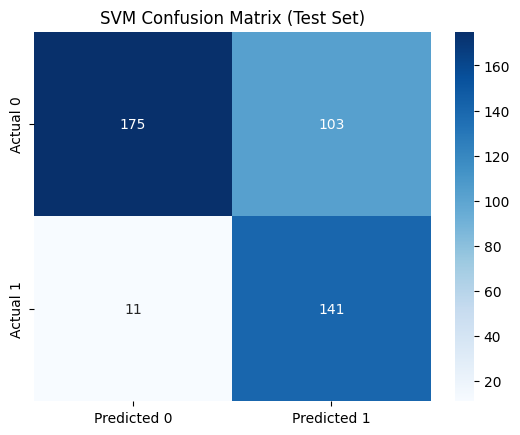


--- Eindevaluatie: {name} (on Test Set) ---
(τ): 0.2012
              precision    recall  f1-score   support

           0       0.94      0.53      0.67       278
           1       0.52      0.93      0.67       152

    accuracy                           0.67       430
   macro avg       0.73      0.73      0.67       430
weighted avg       0.79      0.67      0.67       430



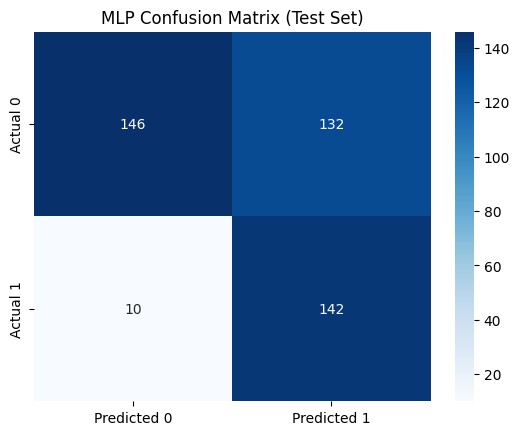

In [136]:
def confusion_matrix_plot(y_test, y_pred_test, name):
    cm = confusion_matrix(y_test, y_pred_test)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f"{name} Confusion Matrix (Test Set)")
    plt.savefig(f'plots/confuse_matr_{name}.png')
    plt.show()


def test_set_evaluator(grid_search_model, optimal_tau, y_test, X_test, name):
    y_probas_test = grid_search_model.best_estimator_.predict_proba(X_test)[:, 1]
    y_pred_test = (y_probas_test >= optimal_tau).astype(int)

    print("\n--- Eindevaluatie: {name} (on Test Set) ---")
    print(f"(τ): {optimal_tau:.4f}")
    print(classification_report(y_test, y_pred_test))

    confusion_matrix_plot(y_test, y_pred_test, name)

    
test_set_evaluator(grid_search_svm, optimal_tau_svm, y_test, X_test, 'SVM')
test_set_evaluator(grid_search_mlp, optimal_tau_mlp, y_test, X_test, 'MLP')

(τ): 0.3148
              precision    recall  f1-score   support

  Gezond (0)       0.93      0.31      0.46       278
Diagnose (1)       0.43      0.96      0.60       152

    accuracy                           0.54       430
   macro avg       0.68      0.63      0.53       430
weighted avg       0.76      0.54      0.51       430



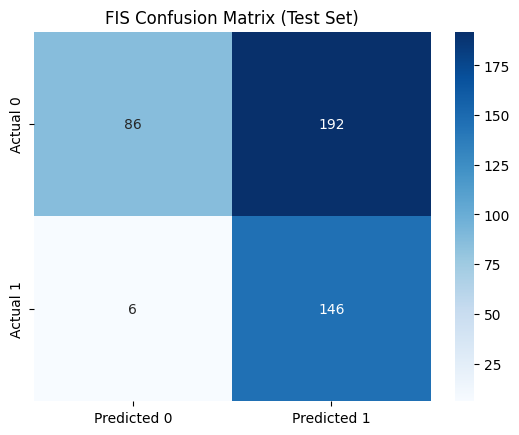

In [137]:
X_test_fis = X_test[fis_features]
y_probas_test_fis = []

for i in range(len(X_test_fis)):
    row = X_test_fis.iloc[i]
    
    fis_simulator.input['age'] = row['age']
    fis_simulator.input['mmse'] = row['mmse']
    fis_simulator.input['functionalassessment'] = row['functionalassessment']
    fis_simulator.input['bmi'] = row['bmi']
    fis_simulator.input['adl'] = row['adl']
    
    fis_simulator.compute()
    risk_score = fis_simulator.output['Risk'] / 100.0
    y_probas_test_fis.append(risk_score)

y_pred_test_fis = (np.array(y_probas_test_fis) >= optimal_tau_fis).astype(int)

print(f"(τ): {optimal_tau_fis:.4f}")
print(classification_report(y_test, y_pred_test_fis, target_names=[f'Gezond (0)', f'Diagnose ({target})']))

confusion_matrix_plot(y_test, y_pred_test_fis, 'FIS')